In [ ]:
!pip install --no-index --upgrade pip

In [ ]:
!pip install --no-index tensorflow-gpu

In [ ]:
!pip install --no-index matplotlib

In [1]:
import tensorflow as tf
#import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import io
import unicodedata
import re
import gc
from collections import Counter

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Preprocessing: Tokenize, clean-up, load, padding

### Tokenize and clean up data

In [4]:
# Lower case for the translation
# Load original english text as is
# install requirement.txt
# python -m spacy download fr_core_news_sm
# correction of tokenizer.py: add encoding='utf-8' to open method
# same thing for punctuation_remover.py
# python tokenizer.py --input train.lang2 --output tokenized --lang fr --keep-empty-lines
# python punctuation_remover.py --input train.lang2.tok --output tokenized


In [5]:
print(tf.__version__)

2.1.0


### Loading data 

In [8]:
# Load data
DIRECTORY_URL = "data/train/"
FILE_NAMES = ["train.lang1","train.lang2"]

#en_data = tf.data.TextLineDataset(os.path.join(DIRECTORY_URL, FILE_NAMES[0]))
#fr_data = tf.data.TextLineDataset(os.path.join(DIRECTORY_URL, FILE_NAMES[1]))

In [9]:
decoder_input_text = []
decoder_target_text = []

with open(os.path.join(DIRECTORY_URL, FILE_NAMES[1]), 'r', encoding="UTF-8") as fr_file:
    for line in fr_file.readlines():
        line = line.rstrip().split('\n')

        target_line = line[0]+" <eos>"
        input_line = "<bos> "+line[0]

        decoder_input_text.append(input_line)
        decoder_target_text.append(target_line)
    fr_file.close()

In [10]:
decoder_input_text[0:3]

['<bos> L’ idée de concilier les différences religieuses semble donc dangereuse .',
 '<bos> Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .',
 '<bos> La réticence doit laisser place à une politique stimulante .']

In [11]:
decoder_target_text[0:3]

['L’ idée de concilier les différences religieuses semble donc dangereuse . <eos>',
 'Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité . <eos>',
 'La réticence doit laisser place à une politique stimulante . <eos>']

In [12]:
encoder_input_text = []
with open(os.path.join(DIRECTORY_URL, FILE_NAMES[0]), 'r', encoding="UTF-8") as en_file:
    for line in en_file.readlines():
        line = line.rstrip().split('\n')
        encoder_input_text.append(line[0]+" .")
    en_file.close()

In [13]:
encoder_input_text[0:3]

['so too does the idea that accommodating religious differences is dangerous .',
 'mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be .',
 'reserve should turn into thought - provoking policy .']

In [14]:
len(encoder_input_text), len(decoder_input_text), len(decoder_target_text)

(11000, 11000, 11000)

### Encoding

In [15]:
input_tokenizer = tf.keras.preprocessing.text.Tokenizer()
input_tokenizer.fit_on_texts(encoder_input_text)
input_integer_seq = input_tokenizer.texts_to_sequences(encoder_input_text)

word2idx_inputs = input_tokenizer.word_index
num_words_input = len(word2idx_inputs) + 1
print('Total unique words in the input: %s' % num_words_input)


max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 13538
Length of longest sentence in input: 91


In [16]:
input_integer_seq[0]

[42, 155, 118, 1, 338, 8, 7411, 966, 1366, 7, 823]

In [17]:
en_sen_len = [len(tok) for tok in input_integer_seq]
en_sen_len[0:5]

[11, 35, 7, 14, 24]

In [18]:
def cut_sentences(text, max_len):
    short_sentences = []
    i=0
    for t in text:
        print(t)
        print(t[:max_len])
        short_sentences.append(t[:max_len])
        i+=1
        if i==10: break
            
    return short_sentences      
    

In [19]:
short = cut_sentences(input_integer_seq, 10)

[42, 155, 118, 1, 338, 8, 7411, 966, 1366, 7, 823]
[42, 155, 118, 1, 338, 8, 7411, 966, 1366, 7]
[40, 48, 272, 4, 280, 1, 172, 967, 4377, 1, 1245, 2, 1, 84, 75, 617, 131, 561, 102, 21, 122, 21, 2001, 6, 257, 13, 94, 617, 4, 3231, 108, 562, 31, 22, 15]
[40, 48, 272, 4, 280, 1, 172, 967, 4377, 1]
[2352, 46, 640, 88, 582, 7412, 95]
[2352, 46, 640, 88, 582, 7412, 95]
[10, 7, 52, 2353, 2588, 8, 11, 30, 79, 2166, 190, 186, 4, 2354]
[10, 7, 52, 2353, 2588, 8, 11, 30, 79, 2166]
[1, 29, 64, 25, 3740, 2355, 406, 85, 60, 1000, 1528, 20, 318, 1719, 2356, 4, 3232, 2, 60, 1367, 16, 5447, 24, 691]
[1, 29, 64, 25, 3740, 2355, 406, 85, 60, 1000]
[7413, 61, 23, 1302, 68]
[7413, 61, 23, 1302, 68]
[27, 28, 1, 583, 1, 887, 180, 59, 99, 12, 57, 202, 7, 39, 11, 18, 14, 1, 1132, 1, 1303, 80, 4, 96, 80, 5, 446, 1846, 4, 7414, 26, 46, 2357, 5, 888]
[27, 28, 1, 583, 1, 887, 180, 59, 99, 12]
[119, 800, 2, 1, 1447, 2, 63, 3, 1036, 3, 410, 102]
[119, 800, 2, 1, 1447, 2, 63, 3, 1036, 3]
[6, 7415, 388, 3, 1, 1001, 37

In [20]:
output_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
output_tokenizer.fit_on_texts(decoder_input_text + decoder_target_text)


output_integer_seq       = output_tokenizer.texts_to_sequences(decoder_target_text)
output_input_integer_seq = output_tokenizer.texts_to_sequences(decoder_input_text)

word2idx_outputs = output_tokenizer.word_index
num_words_output = len(word2idx_outputs) + 2
print('Total unique words in the output: %s' % num_words_output)


max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 17364
Length of longest sentence in the output: 113


In [21]:
fr_sen_len = [len(tok) for tok in output_integer_seq]

In [22]:
np.sort(np.unique(np.array(en_sen_len), return_counts=True),axis=1)

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  67,  70,  71,
         75,  77,  80,  86,  89,  91],
       [  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   3,   3,   3,
          4,   4,   5,   7,   8,  11,  22,  61,  71,  80,  93, 101, 123,
        143, 151, 177, 187, 204, 214, 221, 249, 273, 276, 297, 300, 305,
        347, 349, 353, 361, 365, 375, 379, 380, 380, 385, 387, 391, 396,
        398, 412, 422, 424, 425, 441]], dtype=int64)

In [23]:
np.sort(np.unique(np.array(fr_sen_len), return_counts=True),axis=1)

array([[  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  64,  67,  68,  69,  71,
         73,  75,  77,  79,  80,  81,  82,  83,  85,  86,  87,  95,  99,
        103, 105, 112, 113],
       [  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   3,   3,
          4,   4,   4,   5,   5,   8,   8,   9,  14,  15,  21,  35,  54,
         60,  60,  85, 107, 120, 131, 137, 140, 165, 168, 176, 183, 207,
        216, 219, 247, 250, 259, 260, 267, 267, 269, 276, 290, 290, 293,
        297, 302, 304, 307, 320, 323, 328, 332, 335, 335, 336, 343, 345,
        346, 347, 358, 377]], dtype=int64)

### Padding

In [24]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[0]:", encoder_input_sequences[0])

encoder_input_sequences.shape: (11000, 91)
encoder_input_sequences[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   42  155  118    1
  338    8 7411  966 1366    7  823]


In [25]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[0]:", decoder_input_sequences[0])

decoder_input_sequences.shape: (11000, 113)
decoder_input_sequences[0]: [   5   33  283    2 3485    9 1408 3053  358   85 4097    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [26]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[0]:", decoder_output_sequences[0])

decoder_output_sequences.shape: (11000, 113)
decoder_output_sequences[0]: [  33  283    2 3485    9 1408 3053  358   85 4097    1    6    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [27]:
def preprocess_input_text(text):
    
    #Encoding
    input_tokenizer = tf.keras.preprocessing.text.Tokenizer()
    input_tokenizer.fit_on_texts(text)
    input_encoded = input_tokenizer.texts_to_sequences(text)
    # Padding
    input_padded = pad_sequences(input_encoded, maxlen=max_input_len)
    
    return input_padded

In [28]:
def preprocess_output_text(text, max_len):
    
    #Encoding
    input_tokenizer = tf.keras.preprocessing.text.Tokenizer()
    input_tokenizer.fit_on_texts(text)
    input_encoded = input_tokenizer.texts_to_sequences(text)
    # Padding
    input_padded = pad_sequences(input_encoded, maxlen=max_input_len)
    
    return input_padded

### Define the seq2seq model

In [29]:
# configure problem
embedings_dim = 64
hidden_units = 512
LR = 0.001
dropout = 0.5

In [30]:
#en_vocab_size, en_max_len, fr_vocab_size, fr_max_len, hidden_units, embedings_dim, LR

In [38]:
# Encoder
def seq2seq_model(num_en_tokens, embedings_dim, hidden_units, num_fr_tokens, max_input_len, max_out_len, LR, dropout):      
    
    encoder_inputs = layers.Input(shape=(None,))
    encoder_embeddings = layers.Embedding(num_en_tokens, embedings_dim, mask_zero=True)
    encoder_embedded = encoder_embeddings(encoder_inputs)
    encoder_bilstm = layers.Bidirectional(layers.LSTM(hidden_units, return_state=True, dropout=dropout))
    # Return states in addition to output
    output, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_embedded)
    
    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    #encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Decoder
    decoder_inputs = layers.Input(shape=(None, ))
    decoder_embeddings = layers.Embedding(num_fr_tokens, embedings_dim, mask_zero=True)
    decoder_embedded = decoder_embeddings(decoder_inputs)

    # Pass the 2 states to a new LSTM layer, as initial state
    decoder_lstm = layers.LSTM(hidden_units*2, return_sequences=True, return_state=True, dropout=dropout)
    decoder_outputs, _, _, = decoder_lstm(decoder_embedded, initial_state=encoder_states)

    decoder_dense = layers.Dense(num_fr_tokens, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.2, decay=1e-4, momentum=0.9, nesterov=True), #Adam(learning_rate=LR),
                  metrics=['accuracy'])
    model.summary()
    #sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
    
    # Evaluation model:
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_h = layers.Input(shape=(hidden_units*2,))
    decoder_state_c = layers.Input(shape=(hidden_units*2,))
    #decoder_state_b_h = layers.Input(shape=(hidden_units,))
    #decoder_state_b_c = layers.Input(shape=(hidden_units,))
    
    #e_state_h = layers.Concatenate()([decoder_state_f_h, decoder_state_b_h])
    #e_state_c = layers.Concatenate()([decoder_state_f_c, decoder_state_b_c])
    
    decoder_states_inputs = [decoder_state_h, decoder_state_c]#, decoder_state_b_h, decoder_state_b_c]
    
    decoder_inputs_single = layers.Input(shape=(1,))
    decoder_inputs_single_x = decoder_embeddings(decoder_inputs_single)
    decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
    decoder_states = [h, c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs_single] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )
     
    
    return model, encoder_model, decoder_model

In [39]:
model,_,_ = seq2seq_model(num_words_input, embedings_dim, hidden_units, num_words_output, max_input_len, max_out_len, LR, dropout)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     866432      input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 1024), (None 2363392     embedding_2[0][0]                
____________________________________________________________________________________________

### Train the model

In [40]:
batch_size = 20
epochs=100

In [41]:
encoder_input_sequences.shape

(11000, 91)

In [42]:
decoder_input_sequences.shape

(11000, 113)

In [43]:
decoder_output_sequences.shape

(11000, 113)

In [44]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='baseline2.7.hdf5', verbose=2, save_best_only=True)

history = model.fit([encoder_input_sequences, decoder_input_sequences],
                            decoder_output_sequences,
                            batch_size=batch_size,
                            epochs=epochs, 
                            validation_split=0.2,
                            callbacks=[checkpointer])

Train on 8800 samples, validate on 2200 samples
Epoch 1/100
8780/8800 [============================>.] - ETA: 0s - loss: 1.4878 - accuracy: 0.0641
Epoch 00001: val_loss improved from inf to 1.37904, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 159s 18ms/sample - loss: 1.4879 - accuracy: 0.0642 - val_loss: 1.3790 - val_accuracy: 0.0835
Epoch 2/100
8780/8800 [============================>.] - ETA: 0s - loss: 1.3462 - accuracy: 0.0871
Epoch 00002: val_loss improved from 1.37904 to 1.36537, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 152s 17ms/sample - loss: 1.3463 - accuracy: 0.0871 - val_loss: 1.3654 - val_accuracy: 0.1096
Epoch 3/100
8780/8800 [============================>.] - ETA: 0s - loss: 1.3218 - accuracy: 0.1134
Epoch 00003: val_loss improved from 1.36537 to 1.34717, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 150s 17ms/sample - loss: 1.3214 - accuracy: 0.1134 - val_loss: 1.3472 -

Epoch 26/100
8780/8800 [============================>.] - ETA: 0s - loss: 1.0715 - accuracy: 0.1889
Epoch 00026: val_loss improved from 1.15980 to 1.15791, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 151s 17ms/sample - loss: 1.0716 - accuracy: 0.1888 - val_loss: 1.1579 - val_accuracy: 0.1826
Epoch 27/100
8780/8800 [============================>.] - ETA: 0s - loss: 1.0662 - accuracy: 0.1905
Epoch 00027: val_loss improved from 1.15791 to 1.15629, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 150s 17ms/sample - loss: 1.0661 - accuracy: 0.1905 - val_loss: 1.1563 - val_accuracy: 0.1832
Epoch 28/100
8780/8800 [============================>.] - ETA: 0s - loss: 1.0609 - accuracy: 0.1923
Epoch 00028: val_loss improved from 1.15629 to 1.15428, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 150s 17ms/sample - loss: 1.0610 - accuracy: 0.1923 - val_loss: 1.1543 - val_accuracy: 0.1849
Epoch 29/100
8780/8

Epoch 52/100
8780/8800 [============================>.] - ETA: 0s - loss: 0.9548 - accuracy: 0.2298
Epoch 00052: val_loss improved from 1.13117 to 1.13034, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 150s 17ms/sample - loss: 0.9547 - accuracy: 0.2298 - val_loss: 1.1303 - val_accuracy: 0.2017
Epoch 53/100
8780/8800 [============================>.] - ETA: 0s - loss: 0.9509 - accuracy: 0.2311
Epoch 00053: val_loss improved from 1.13034 to 1.12948, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 151s 17ms/sample - loss: 0.9508 - accuracy: 0.2311 - val_loss: 1.1295 - val_accuracy: 0.2003
Epoch 54/100
8780/8800 [============================>.] - ETA: 0s - loss: 0.9473 - accuracy: 0.2323
Epoch 00054: val_loss improved from 1.12948 to 1.12881, saving model to baseline2.7.hdf5
8800/8800 [==============================] - 167s 19ms/sample - loss: 0.9471 - accuracy: 0.2323 - val_loss: 1.1288 - val_accuracy: 0.1991
Epoch 55/100
8780/8

8780/8800 [============================>.] - ETA: 0s - loss: 0.8626 - accuracy: 0.2687
Epoch 00079: val_loss did not improve from 1.12701
8800/8800 [==============================] - 146s 17ms/sample - loss: 0.8625 - accuracy: 0.2687 - val_loss: 1.1300 - val_accuracy: 0.2029
Epoch 80/100
8780/8800 [============================>.] - ETA: 0s - loss: 0.8598 - accuracy: 0.2691
Epoch 00080: val_loss did not improve from 1.12701
8800/8800 [==============================] - 146s 17ms/sample - loss: 0.8598 - accuracy: 0.2691 - val_loss: 1.1302 - val_accuracy: 0.2007
Epoch 81/100
8780/8800 [============================>.] - ETA: 0s - loss: 0.8567 - accuracy: 0.2707
Epoch 00081: val_loss did not improve from 1.12701
8800/8800 [==============================] - 146s 17ms/sample - loss: 0.8568 - accuracy: 0.2708 - val_loss: 1.1308 - val_accuracy: 0.2017
Epoch 82/100
8780/8800 [============================>.] - ETA: 0s - loss: 0.8534 - accuracy: 0.2717
Epoch 00082: val_loss did not improve from 1.1

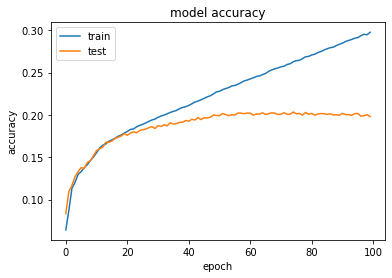

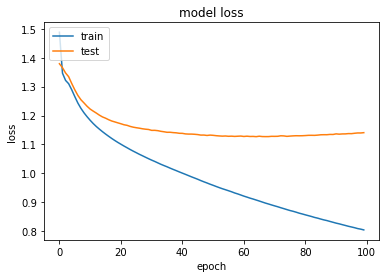

In [45]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file = "seq2seq_translation.png", show_shapes = True)

## Evaluation

In [46]:
_, encoder_model, decoder_model = seq2seq_model(num_words_input, embedings_dim, hidden_units, num_words_output, max_input_len, max_out_len, LR, dropout)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 64)     866432      input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 1024), (None 2363392     embedding_4[0][0]                
____________________________________________________________________________________________

In [47]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [50]:
def translate_sentence(input_seq):
    
    #print(input_seq.shape)
    input_seq = input_seq.reshape(-1,max_input_len)
    states_value = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<bos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []
    
    #print("Translating sequence: ", input_seq)
    for _ in range(max_out_len):
        
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
            #print("Predicting word "+word+"for index "+str(idx))

        target_seq[0, 0] = idx
        states_value = [h, c]
        
        

    return ' '.join(output_sentence)

In [51]:
i = 1
input_seq = encoder_input_sequences[i]
translation = translate_sentence(input_seq)

print('Input:', encoder_input_text[i])
print('==============================')
print('Response:', translation)

Input: mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be .
Response: blâme inquiétantes cinquantième permettent caractérisée collaboré nexi purifier pirates ironique louable support support optique deviez shah ankara placez placez mortalité épargnerait épargnerait épargnerait épargnerait épargnerait purifier naturelles réparer tremblent turc dispersées héritées optimisme habillement participent masses millions veillons radicalement radicalement sandiniste créerait résistent traducteur remise constat symphony objecteront objecteront cachet préservions place collectives n' créances fécule réel attrapées 1977 émancipatrices émancipatrices inciterais familiales capables — espèce défendre clairvoyance financés recueillir extraire janvier janvier cohérents difficulté individuelles préféré renforcées préféré renforcées baisse té

In [60]:
text_inputs = []
with open(os.path.join(DIRECTORY_URL, FILE_NAMES[0]), 'r', encoding='utf-8') as en_file:
    input_text = en_file.readlines()
    en_file.close() 
print(input_text[0:5])
input_text = input_text[0:5]

['so too does the idea that accommodating religious differences is dangerous\n', 'mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be\n', 'reserve should turn into thought - provoking policy\n', 'it is my profound belief that we can only advance through cooperation and negotiation\n', 'the european union has territorial waters greater than its entire territory with 1 200 ports and 90 % of its exports are transported by sea\n']


In [61]:
with open("text_inputs.txt", "w", encoding='utf-8') as in_file:
    in_file.writelines(input_text)
    in_file.close()

In [62]:
targets = []
with open(os.path.join(DIRECTORY_URL, FILE_NAMES[1]), 'r', encoding='utf-8') as fr_file:
    targets = fr_file.readlines()
    fr_file.close() 
print(targets[0:5])
targets = targets[0:5]

['L’ idée de concilier les différences religieuses semble donc dangereuse .\n', 'Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .\n', 'La réticence doit laisser place à une politique stimulante .\n', 'Je suis intimement convaincu que nous ne pourrons progresser que si nous coopérons et négocions .\n', "Le territoire marin de l' Union européenne est plus vaste que son territoire terrestre . On y dénombre 1 200 ports et 90 % de ses exportations sont acheminées par mer .\n"]


In [63]:
with open("targets.txt", "w", encoding='utf-8') as target_file:
    target_file.writelines(targets)
    target_file.close()

In [64]:
from pathlib import Path
def open_file(file_to_open):
    input_text = []
    with open(Path(file_to_open), 'r', encoding="UTF-8") as f:
        for line in f.readlines():
            line = line.rstrip().split('\n')
            input_text.append(line[0])
        f.close()
    return input_text

In [65]:
def prep_input_text(input_text):
    input_text = input_tokenizer.texts_to_sequences(input_text)
    input_text = pad_sequences(input_text, maxlen=max_input_len)
    return input_text

In [66]:
from pathlib import Path

# Load model parameters
#model.load_weights("baseline2.h5")
args_input_file_path = "text_inputs.txt"
#pred_file_path = "predictions.txt"

# Load text input
eval_input_text = open_file(args_input_file_path)

# Preprocess input
input_prep = prep_input_text(eval_input_text)

# Run prediction
translations = []
for text in input_prep:
    translations.append(translate_sentence(text)+"\n")

# Save to file
with open("predictions.txt", "w", encoding='utf-8') as target_file:
    target_file.writelines(translations)
    target_file.close()

## SacreBLEU Evaluation 
['0.3', '0.2', '0.3', '0.2', '0.3', '']

final avg bleu score: 0.26